<a href="https://colab.research.google.com/github/nichsedge/ai-agents-with-langchain-langgraph/blob/main/HealthBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install --quiet langchain-core langchain-openai langchain-chroma langgraph ragas tavily-python

In [8]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from dotenv import load_dotenv
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness
from ragas import messages as ragas_messages
from ragas.integrations.langgraph import convert_to_ragas_messages
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import ToolCallAccuracy
from ragas.metrics import AgentGoalAccuracyWithReference
from tavily import TavilyClient
from typing import Dict

In [9]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')
OPENAI_API_BASE = "https://openai.vocareum.com/v1"
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

In [10]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    base_url=OPENAI_API_BASE,
    api_key=OPENAI_API_KEY
)

@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=TAVILY_API_KEY)
    response = tavily_client.search(question)
    return response

In [38]:
"""
HealthBot: AI-Powered Patient Education System
A LangGraph-based workflow for patient education and comprehension testing.
Strictly follows project requirements with proper API configuration and state management.
"""

import os
from typing import Dict, Any, List, Optional, TypedDict, Annotated
from datetime import datetime

# LangGraph and LangChain imports
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


class HealthBotState(TypedDict):
    """
    State definition for the HealthBot workflow.
    Tracks all data created, updated, and referenced by nodes.
    """
    # Core workflow data
    topic: str
    search_results: str
    summary: str
    quiz_question: str
    user_answer: str
    grade: str
    grade_justification: str

    # Workflow control
    continue_learning: bool
    workflow_complete: bool

    # Message history for LLM context
    messages: Annotated[List[BaseMessage], add_messages]

    # Current step tracking
    current_step: str


class HealthBot:
    """AI-Powered Patient Education System using LangGraph"""

    def __init__(self):
        """
        Initialize the HealthBot with API configurations
        API keys must be set as environment variables:
        - OPENAI_API_KEY
        - TAVILY_API_KEY
        """

        # Configure OpenAI LLM
        self.llm = ChatOpenAI(
            base_url=OPENAI_API_BASE,
            api_key=OPENAI_API_KEY,
            model="gpt-4o-mini",
            temperature=0.3
        )

        # Configure Tavily Search Tool
        self.search_tool = TavilySearchResults(
            tavily_api_key=TAVILY_API_KEY,
            max_results=5,
            search_depth="advanced"
        )

        # Test API connections
        self._test_api_connections()

        # Build and compile the workflow
        self.workflow = self._build_workflow()
        self.app = self.workflow.compile()

    def _test_api_connections(self):
        """Test API connections to ensure proper configuration"""
        try:
            # Test OpenAI connection
            test_response = self.llm.invoke([HumanMessage(content="Hello")])
            print("✅ OpenAI API connection successful")

            # Test Tavily connection
            test_search = self.search_tool.run("health")
            print("✅ Tavily API connection successful")

        except Exception as e:
            print(f"❌ API connection failed: {str(e)}")
            raise

    def _build_workflow(self) -> StateGraph:
        """Build the LangGraph workflow with proper nodes and edges"""

        workflow = StateGraph(HealthBotState)

        # Add workflow nodes with single responsibilities
        workflow.add_node("get_topic", self._get_topic_node)
        workflow.add_node("search_information", self._search_information_node)
        workflow.add_node("summarize_results", self._summarize_results_node)
        workflow.add_node("present_summary", self._present_summary_node)
        workflow.add_node("create_quiz", self._create_quiz_node)
        workflow.add_node("get_user_answer", self._get_user_answer_node)
        workflow.add_node("grade_answer", self._grade_answer_node)
        workflow.add_node("present_grade", self._present_grade_node)
        workflow.add_node("check_continue", self._check_continue_node)
        workflow.add_node("reset_for_new_topic", self._reset_for_new_topic_node)

        # Set entry point
        workflow.set_entry_point("get_topic")

        # Configure sequential workflow edges
        workflow.add_edge("get_topic", "search_information")
        workflow.add_edge("search_information", "summarize_results")
        workflow.add_edge("summarize_results", "present_summary")
        workflow.add_edge("present_summary", "create_quiz")
        workflow.add_edge("create_quiz", "get_user_answer")
        workflow.add_edge("get_user_answer", "grade_answer")
        workflow.add_edge("grade_answer", "present_grade")
        workflow.add_edge("present_grade", "check_continue")

        # Conditional edge for workflow continuation
        workflow.add_conditional_edges(
            "check_continue",
            self._should_continue_or_exit,
            {
                "continue": "reset_for_new_topic",
                "exit": END
            }
        )

        workflow.add_edge("reset_for_new_topic", "get_topic")

        return workflow

    def _get_topic_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Collect learning topic from user"""

        print("\n" + "="*60)
        print("🏥 HealthBot: AI-Powered Patient Education System")
        print("="*60)

        if state.get("current_step") != "restart":
            print("Welcome! I'll help you learn about health topics through")
            print("research, summarization, and comprehension testing.")

        print(f"\nWhat health topic would you like to learn about?")
        topic = input("Enter your topic: ").strip()

        while not topic:
            topic = input("Please enter a valid health topic: ").strip()

        # Update state
        state["topic"] = topic
        state["current_step"] = "topic_collected"
        state["messages"] = [HumanMessage(content=f"User wants to learn about: {topic}")]

        print(f"\n📚 Learning topic selected: {topic}")

        return state

    def _search_information_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Search for information using Tavily"""

        print(f"\n🔍 Searching for information about: {state['topic']}")

        try:
            # Construct medical-focused search query
            search_query = f"{state['topic']} medical health information"

            # Call Tavily search API
            search_results = self.search_tool.run(search_query)

            # Process and format search results
            formatted_results = ""
            for i, result in enumerate(search_results, 1):
                if isinstance(result, dict):
                    title = result.get('title', 'No title')
                    content = result.get('content', '')
                    url = result.get('url', '')

                    formatted_results += f"\n--- Source {i} ---\n"
                    formatted_results += f"Title: {title}\n"
                    formatted_results += f"Content: {content}\n"
                    formatted_results += f"URL: {url}\n"

            # Update state with search results
            state["search_results"] = formatted_results
            state["current_step"] = "search_completed"

            # Add to message history
            state["messages"].append(
                AIMessage(content=f"Search completed for '{state['topic']}'. Found {len(search_results)} sources.")
            )

            print("✅ Information search completed successfully")

        except Exception as e:
            print(f"❌ Search failed: {str(e)}")
            raise

        return state

    def _summarize_results_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Summarize search results using OpenAI (no other knowledge sources)"""

        print("\n📝 Creating summary from search results...")

        # Well-written prompt for summarization using ONLY search results
        summarization_prompt = ChatPromptTemplate.from_template("""
        You are a medical information summarizer. Your task is to create a clear,
        patient-friendly summary using ONLY the provided search results. Do not use
        any external knowledge or information beyond what is provided.

        Topic: {topic}

        Search Results to Summarize:
        {search_results}

        Instructions:
        - Create a 3-4 paragraph summary using ONLY the information from the search results above
        - Do not add information from your general medical knowledge
        - Use clear, patient-friendly language
        - Organize the information logically
        - If the search results are insufficient, state that clearly

        Summary:
        """)

        try:
            # Create messages for OpenAI call
            messages = summarization_prompt.format_messages(
                topic=state["topic"],
                search_results=state["search_results"]
            )

            # Call OpenAI to summarize
            response = self.llm.invoke(messages)
            summary = response.content

            # Update state
            state["summary"] = summary
            state["current_step"] = "summary_created"

            # Add to message history
            state["messages"].append(
                AIMessage(content=f"Summary created for '{state['topic']}'")
            )

            print("✅ Summary created from search results")

        except Exception as e:
            print(f"❌ Summarization failed: {str(e)}")
            raise

        return state

    def _present_summary_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Display summary to user"""

        print("\n" + "="*60)
        print(f"📋 SUMMARY: {state['topic'].upper()}")
        print("="*60)
        print()
        print(state["summary"])
        print()
        print("="*60)

        # Wait for user to read
        input("\nPress Enter when you're ready for the quiz...")

        state["current_step"] = "summary_presented"

        return state

    def _create_quiz_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Create quiz question using ONLY the summary data"""

        print("\n🎯 Creating quiz question...")

        # Well-written prompt for quiz creation using ONLY summary data
        quiz_creation_prompt = ChatPromptTemplate.from_template("""
        Create a quiz question using ONLY the information provided in the summary below.
        Do not use any external knowledge beyond what is in the summary.

        Topic: {topic}

        Summary to base quiz on:
        {summary}

        Instructions:
        - Create ONE multiple choice question with 4 options (A, B, C, D)
        - The question must be answerable using ONLY the summary above
        - Make sure only one answer is clearly correct based on the summary
        - Include the correct answer at the end

        Format:
        Question: [Your question]
        A) [Option A]
        B) [Option B]
        C) [Option C]
        D) [Option D]

        Correct Answer: [Letter]
        """)

        try:
            # Create messages for OpenAI call
            messages = quiz_creation_prompt.format_messages(
                topic=state["topic"],
                summary=state["summary"]
            )

            # Call OpenAI to create quiz
            response = self.llm.invoke(messages)
            quiz_question = response.content

            # Update state
            state["quiz_question"] = quiz_question
            state["current_step"] = "quiz_created"

            # Add to message history
            state["messages"].append(
                AIMessage(content=f"Quiz question created for '{state['topic']}'")
            )

            print("✅ Quiz question created")

        except Exception as e:
            print(f"❌ Quiz creation failed: {str(e)}")
            raise

        return state

    def _get_user_answer_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Collect user's answer to quiz question"""

        print("\n" + "="*60)
        print("🧠 QUIZ TIME")
        print("="*60)

        # Extract and display question (without showing correct answer)
        quiz_parts = state["quiz_question"].split("Correct Answer:")
        question_part = quiz_parts[0].strip()

        print(question_part)
        print()

        # Get user answer
        while True:
            answer = input("Enter your answer (A, B, C, or D): ").strip().upper()
            if answer in ['A', 'B', 'C', 'D']:
                break
            print("Please enter A, B, C, or D")

        # Update state
        state["user_answer"] = answer
        state["current_step"] = "answer_collected"

        # Add to message history
        state["messages"].append(
            HumanMessage(content=f"User answered: {answer}")
        )

        return state

    def _grade_answer_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Grade user's answer using ONLY the summary as data source"""

        print("\n📊 Grading your answer...")

        # Well-written prompt for grading using ONLY summary data
        grading_prompt = ChatPromptTemplate.from_template("""
        Grade the user's quiz answer using ONLY the summary provided as your data source.
        Do not use any external knowledge beyond the summary.

        Topic: {topic}

        Summary (your only data source):
        {summary}

        Quiz Question:
        {quiz_question}

        User's Answer: {user_answer}

        Instructions:
        - Grade the answer using ONLY information from the summary above
        - Provide a letter grade (A, B, C, D, or F)
        - Provide detailed justification for the grade based on the summary
        - Explain why the answer is correct or incorrect using summary content

        Format:
        Grade: [Letter Grade]

        Justification: [Detailed explanation using only summary information]
        """)

        try:
            # Create messages for OpenAI call
            messages = grading_prompt.format_messages(
                topic=state["topic"],
                summary=state["summary"],
                quiz_question=state["quiz_question"],
                user_answer=state["user_answer"]
            )

            # Call OpenAI to grade
            response = self.llm.invoke(messages)
            grading_result = response.content

            # Parse grade and justification
            if "Justification:" in grading_result:
                parts = grading_result.split("Justification:", 1)
                grade = parts[0].replace("Grade:", "").strip()
                justification = parts[1].strip()
            else:
                grade = "Unable to grade"
                justification = grading_result

            # Update state
            state["grade"] = grade
            state["grade_justification"] = justification
            state["current_step"] = "answer_graded"

            # Add to message history
            state["messages"].append(
                AIMessage(content=f"Answer graded: {grade}")
            )

            print("✅ Answer graded")

        except Exception as e:
            print(f"❌ Grading failed: {str(e)}")
            raise

        return state

    def _present_grade_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Display grade and justification to user"""

        print("\n" + "="*60)
        print("📈 QUIZ RESULTS")
        print("="*60)

        print(f"\nYour Answer: {state['user_answer']}")
        print(f"Grade: {state['grade']}")
        print(f"\nJustification:")
        print(state['grade_justification'])

        print("\n" + "="*60)

        state["current_step"] = "grade_presented"

        return state

    def _check_continue_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Ask user if they want to learn about another topic or exit"""

        print("\n" + "-"*40)

        while True:
            choice = input("\nWould you like to learn about another topic? (yes/no): ").strip().lower()

            if choice in ['yes', 'y']:
                state["continue_learning"] = True
                state["workflow_complete"] = False
                break
            elif choice in ['no', 'n']:
                state["continue_learning"] = False
                state["workflow_complete"] = True
                print("\n👋 Thank you for using HealthBot!")
                break
            else:
                print("Please enter 'yes' or 'no'")

        state["current_step"] = "continue_checked"

        return state

    def _should_continue_or_exit(self, state: HealthBotState) -> str:
        """Conditional function: Determine workflow direction"""
        return "continue" if state.get("continue_learning", False) else "exit"

    def _reset_for_new_topic_node(self, state: HealthBotState) -> HealthBotState:
        """Node: Reset state for new topic while preserving message history"""

        # Preserve message history
        previous_messages = state.get("messages", [])

        # Reset workflow-specific state
        state.update({
            "topic": "",
            "search_results": "",
            "summary": "",
            "quiz_question": "",
            "user_answer": "",
            "grade": "",
            "grade_justification": "",
            "continue_learning": False,
            "workflow_complete": False,
            "current_step": "restart",
            "messages": previous_messages
        })

        print("\n🔄 Ready for new topic...")

        return state

    def run_session(self):
        """
        Run a complete HealthBot session
        Executes the entire workflow per requirements
        """

        # Initialize state with all required properties
        initial_state = HealthBotState(
            topic="",
            search_results="",
            summary="",
            quiz_question="",
            user_answer="",
            grade="",
            grade_justification="",
            continue_learning=False,
            workflow_complete=False,
            messages=[],
            current_step="start"
        )

        try:
            print("🚀 Starting HealthBot session...")

            # Execute the complete workflow
            final_state = self.app.invoke(initial_state)

            print("\n✅ HealthBot session completed successfully!")
            return final_state

        except KeyboardInterrupt:
            print("\n\n⚠️ Session interrupted by user")
            return initial_state

        except Exception as e:
            print(f"\n❌ Session error: {str(e)}")
            raise


def main():
    """
    Main function to run the HealthBot
    Demonstrates proper API configuration and workflow execution
    """

    print("HealthBot: AI-Powered Patient Education System")
    print("=" * 50)

    try:
        # Initialize HealthBot with proper API configuration
        healthbot = HealthBot()

        # Run the complete workflow
        final_state = healthbot.run_session()

        print(f"\n📊 Session Summary:")
        print(f"- Topics covered: {len([m for m in final_state.get('messages', []) if 'learn about:' in str(m)])}")
        print(f"- Final step: {final_state.get('current_step', 'unknown')}")

    except Exception as e:
        print(f"❌ Failed to run HealthBot: {str(e)}")
        print("Please check your API keys and try again.")


if __name__ == "__main__":
    main()

HealthBot: AI-Powered Patient Education System
✅ OpenAI API connection successful
✅ Tavily API connection successful
🚀 Starting HealthBot session...

🏥 HealthBot: AI-Powered Patient Education System
Welcome! I'll help you learn about health topics through
research, summarization, and comprehension testing.

What health topic would you like to learn about?
Enter your topic: diarrhea

📚 Learning topic selected: diarrhea

🔍 Searching for information about: diarrhea
✅ Information search completed successfully

📝 Creating summary from search results...
✅ Summary created from search results

📋 SUMMARY: DIARRHEA

Diarrhea is a condition characterized by loose and watery stools, often accompanied by an increased frequency of bowel movements. It can be a short-term issue, known as acute diarrhea, which typically lasts for 1 to 2 days. However, some cases may develop into long-term or chronic diarrhea, lasting several weeks. Common symptoms include belly cramps and an urgent need to use the bath

In [36]:
healthbot = HealthBot()

✅ OpenAI API connection successful
✅ Tavily API connection successful


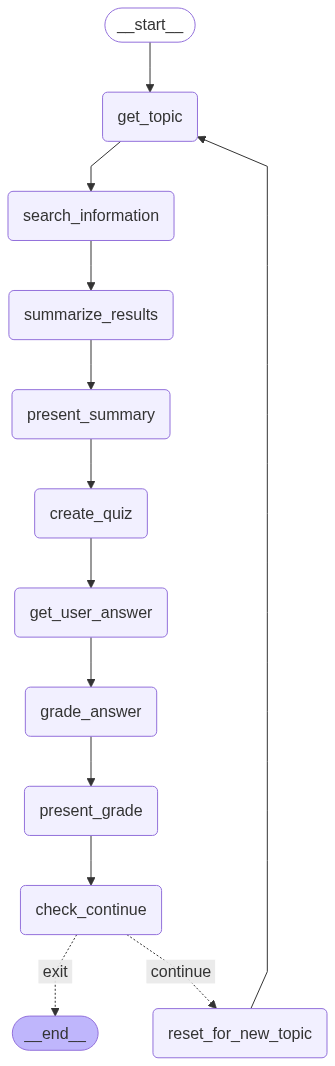

In [37]:
display(
    Image(
        healthbot.app.get_graph().draw_mermaid_png()
    )
)